In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-census-income/adult.csv


In [2]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 5.3 MB/s eta 0:00:00a 0:00:01


In [3]:
# Install required packages with visible progress
!pip install transformers datasets torch fairlearn

# AI Bias Analysis in Income Prediction
## Dataset: Adult Census Income

### Initial Data Loading and Preprocessing
- Dataset contains 32,561 records with 15 features
- Target variable: Income (<=50K, >50K)
- Key demographic features: gender, race, age, education, marital status



In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [5]:
def load_and_examine_data(file_path):
    """
    Load and perform initial examination of the dataset
    """
    # Load data
    adult_df = pd.read_csv(file_path)
    
    # Display basic information
    print("\n=== Dataset Overview ===")
    print("\nDataset Shape:", adult_df.shape)
    print("\nColumns:", adult_df.columns.tolist())
    print("\nData Types:\n", adult_df.dtypes)
    print("\nMissing Values:\n", adult_df.isnull().sum())
    print("\Actual Column names in the dataset:\n", adult_df.columns.tolist())
    
    return adult_df

In [6]:
adult_df = load_and_examine_data("/kaggle/input/adult-census-income/adult.csv")


=== Dataset Overview ===

Dataset Shape: (32561, 15)

Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']

Data Types:
 age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

Missing Values:
 age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [7]:
# Look at the first few rows
print("First few rows of the dataset:")
display(adult_df.head())

# Basic statistics
print("\nBasic statistics of numerical columns:")
display(adult_df.describe())

First few rows of the dataset:


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K



Basic statistics of numerical columns:


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocess_data(adult_df, categorical_columns=None, numerical_columns=None):
    """
    Preprocess the dataset including income column encoding
    
    Parameters:
    adult_df (pd.DataFrame): Input dataframe
    categorical_columns (list): List of categorical column names
    numerical_columns (list): List of numerical column names
    
    Returns:
    pd.DataFrame: Processed dataframe
    """
    df_processed = adult_df.copy()
    
    # First, handle the income column using map
    if 'income' in df_processed.columns:
        df_processed['income'] = df_processed['income'].map({'<=50K': 0, '>50K': 1})
    
    # Handle missing values
    for column in df_processed.columns:
        if df_processed[column].isnull().sum() > 0:
            if df_processed[column].dtype in ['int64', 'float64']:
                df_processed[column].fillna(df_processed[column].median(), inplace=True)
            else:
                df_processed[column].fillna(df_processed[column].mode()[0], inplace=True)
    
    # Remove any '?' values in categorical columns
    if categorical_columns:
        for col in categorical_columns:
            if col in df_processed.columns:
                df_processed[col] = df_processed[col].replace('?', df_processed[col].mode()[0])
    
    # Encode categorical variables (excluding 'income' if it's in categorical_columns)
    if categorical_columns:
        # Remove 'income' from categorical columns if present
        categorical_cols_to_encode = [col for col in categorical_columns if col != 'income']
        if categorical_cols_to_encode:
            df_processed = pd.get_dummies(df_processed, columns=categorical_cols_to_encode)
    
    # Scale numerical features
    if numerical_columns:
        scaler = StandardScaler()
        df_processed[numerical_columns] = scaler.fit_transform(df_processed[numerical_columns])
    
    return df_processed

# Example usage
df = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")
processed_df = preprocess_data(df, categorical_columns=['workclass', 'education'], numerical_columns=['age', 'hours.per.week'])

In [9]:
# Define your categorical and numerical columns
categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 
                      'relationship', 'race', 'sex', 'native.country']
numerical_columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 
                    'capital.loss', 'hours.per.week']

In [10]:
df_processed = preprocess_data(adult_df, categorical_columns, numerical_columns)

### Distribution Analysis
- Gender: Significant imbalance (66.9% male, 33.1% female)
- Race: Heavily skewed towards White (85.4%)
- Age: Normal distribution peaking at 30-40 years
- Education: Majority HS-grad level

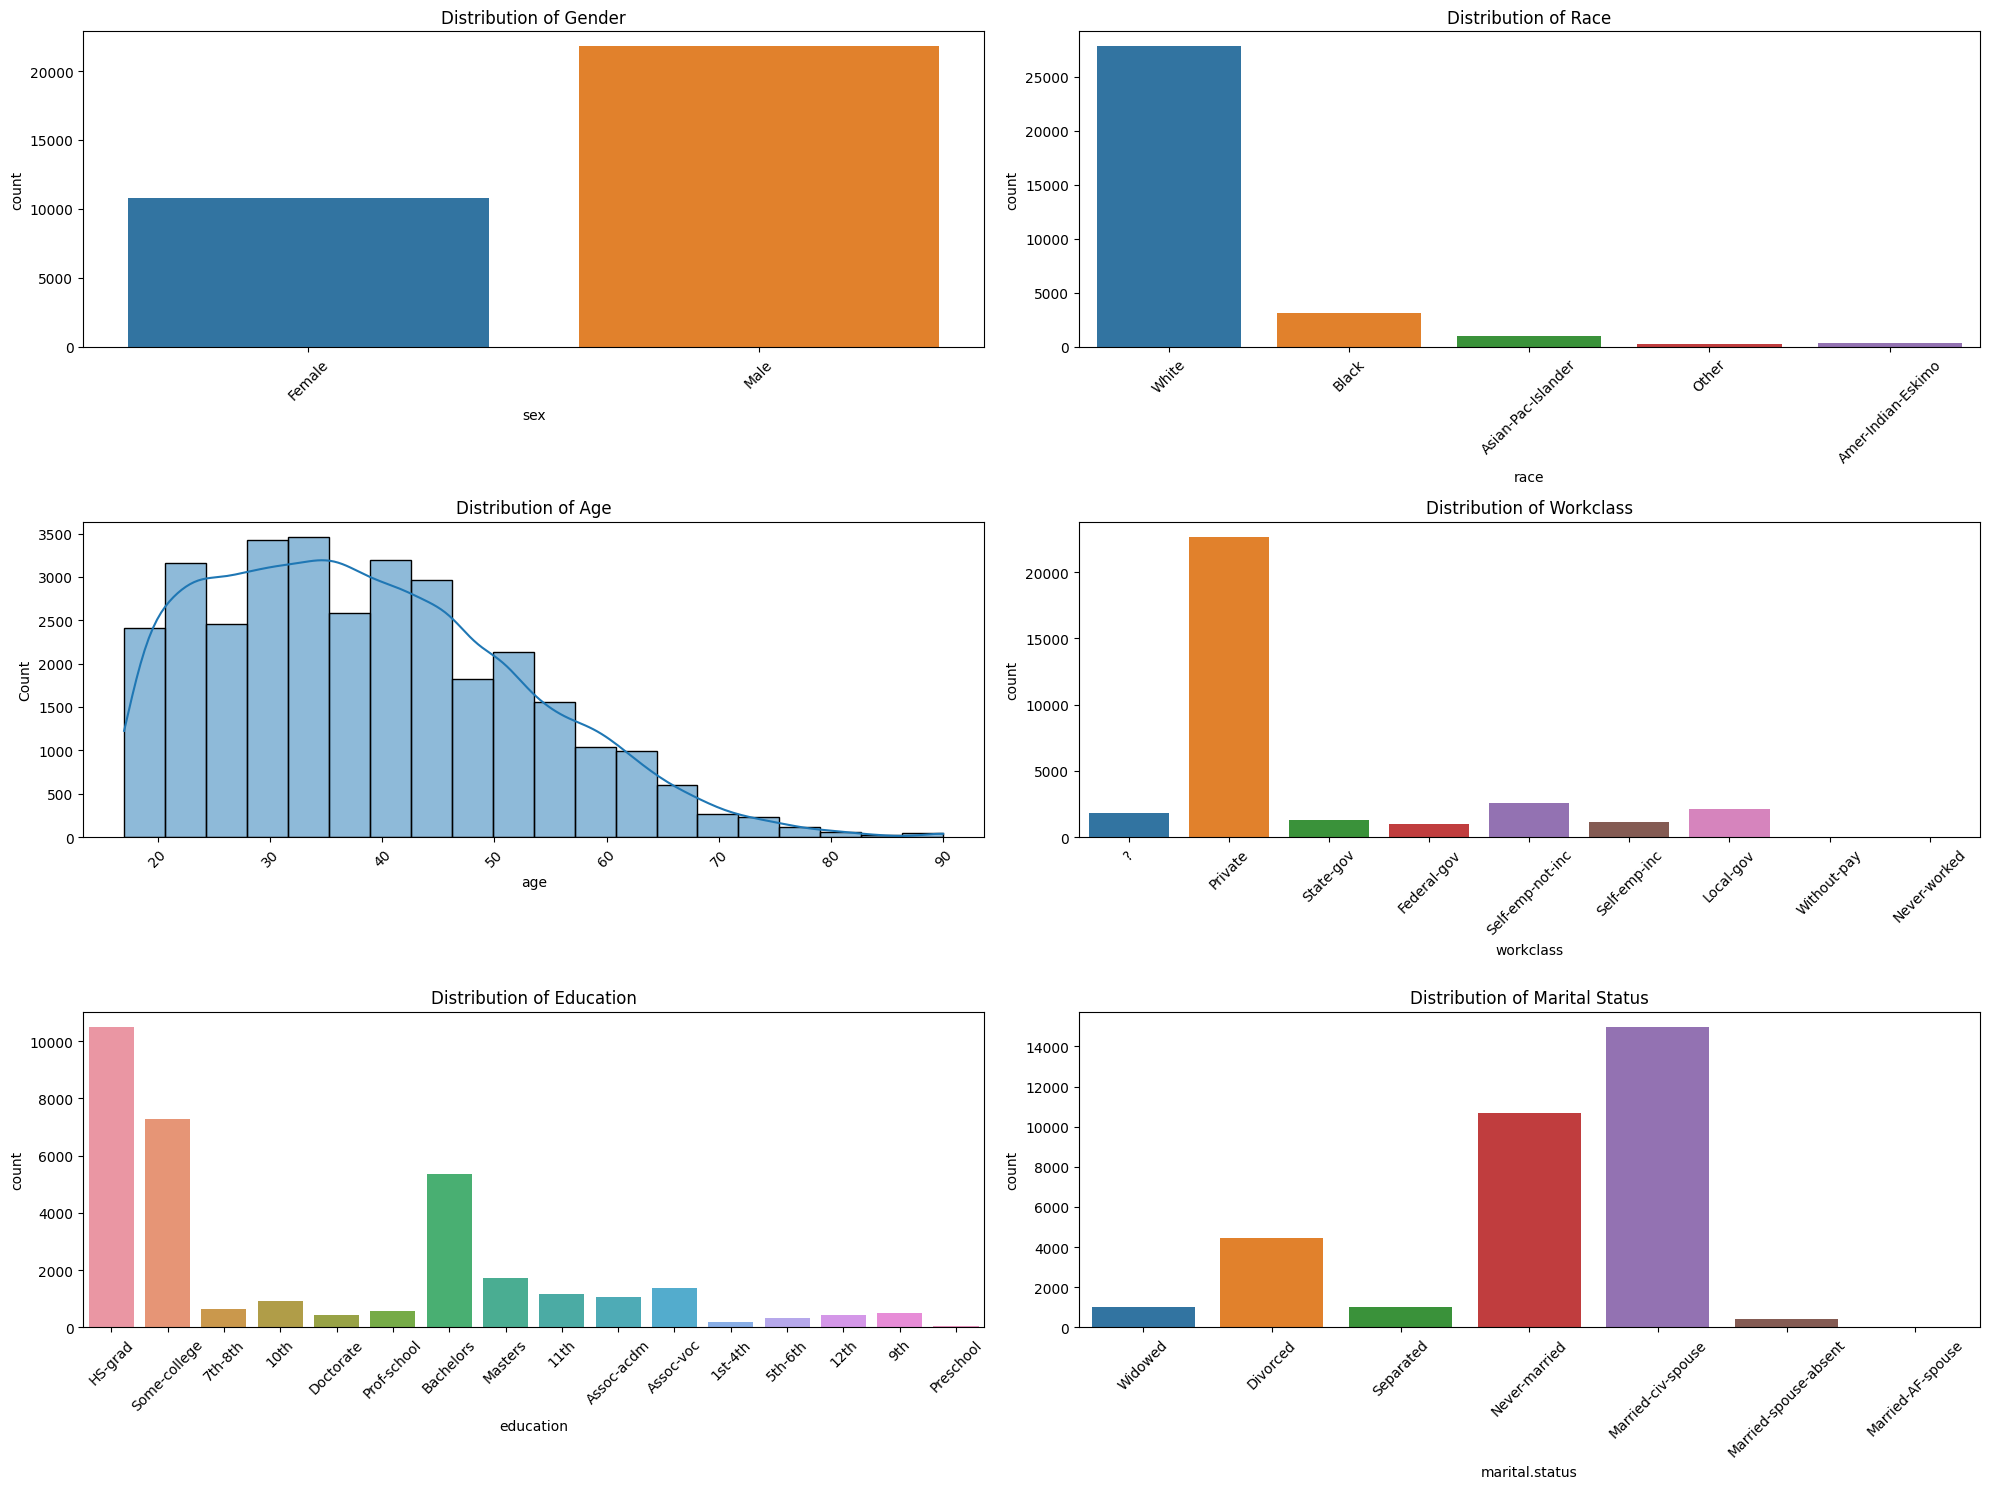

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Assuming `adult_df` is your DataFrame

# Create visualizations for protected attributes
plt.figure(figsize=(20, 15))

# Distribution of gender
plt.subplot(3, 2, 1)
sns.countplot(data=adult_df, x='sex')
plt.title('Distribution of Gender')
plt.xticks(rotation=45)

# Distribution of race
plt.subplot(3, 2, 2)
sns.countplot(data=adult_df, x='race')
plt.title('Distribution of Race')
plt.xticks(rotation=45)

# Distribution of age
plt.subplot(3, 2, 3)
sns.histplot(data=adult_df, x='age', bins=20, kde=True)
plt.title('Distribution of Age')
plt.xticks(rotation=45)

# Distribution of workclass
plt.subplot(3, 2, 4)
sns.countplot(data=adult_df, x='workclass')
plt.title('Distribution of Workclass')
plt.xticks(rotation=45)

# Distribution of education
plt.subplot(3, 2, 5)
sns.countplot(data=adult_df, x='education')
plt.title('Distribution of Education')
plt.xticks(rotation=45)

# Distribution of marital status
plt.subplot(3, 2, 6)
sns.countplot(data=adult_df, x='marital.status')
plt.title('Distribution of Marital Status')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Bias Detection Implementation
- Gender bias analysis
- Race bias analysis
- Marital status bias analysis
- Education bias analysis

In [12]:
def calculate_bias_metrics(adult_df, protected_column, target_column='income'):
    """
    Calculate bias metrics for the dataset
    
    Parameters:
    adult_df (pd.DataFrame): Input dataframe
    protected_column (str): Column name for the protected attribute (e.g., 'sex', 'race')
    target_column (str): Column name for the target attribute (default is 'income')
    
    Returns:Dictionary containing bias metrics
    """
    metrics = {}
    
    # Calculate group-wise statistics
    group_stats = adult_df.groupby(protected_column)[target_column].agg(['count', 'mean'])
    metrics['group_statistics'] = group_stats
    
    # Calculate disparate impact
    group_means = group_stats['mean']
    metrics['disparate_impact'] = min(group_means) / max(group_means)
    
    # Calculate demographic parity difference
    metrics['demographic_parity_diff'] = max(group_means) - min(group_means)
    
    return metrics

In [13]:
df = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")
processed_df = preprocess_data(df, categorical_columns=['workclass', 'education'], numerical_columns=['age', 'hours.per.week'])
print(processed_df.head())

        age  fnlwgt  education.num marital.status         occupation  \
0  3.769612   77053              9        Widowed                  ?   
1  3.183112  132870              9        Widowed    Exec-managerial   
2  2.010110  186061             10        Widowed                  ?   
3  1.130359  140359              4       Divorced  Machine-op-inspct   
4  0.177296  264663             10      Separated     Prof-specialty   

    relationship   race     sex  capital.gain  capital.loss  ...  \
0  Not-in-family  White  Female             0          4356  ...   
1  Not-in-family  White  Female             0          4356  ...   
2      Unmarried  Black  Female             0          4356  ...   
3      Unmarried  White  Female             0          3900  ...   
4      Own-child  White  Female             0          3900  ...   

   education_9th education_Assoc-acdm  education_Assoc-voc  \
0          False                False                False   
1          False                Fa

In [14]:
# Calculate bias metrics for gender and race
gender_metrics = calculate_bias_metrics(processed_df, 'sex')
race_metrics = calculate_bias_metrics(processed_df, 'race')

# Calculate bias metrics for marital status, occupation, and education
marital_status_metrics = calculate_bias_metrics(processed_df, 'marital.status')
occupation_metrics = calculate_bias_metrics(processed_df, 'occupation')
education_metrics = calculate_bias_metrics(processed_df, 'education_Bachelors')

print("Gender Bias Metrics:")
display(gender_metrics)

print("\nRace Bias Metrics:")
display(race_metrics)

print("\nMarital Status Bias Metrics:")
display(marital_status_metrics)

print("\nOccupation Bias Metrics:")
display(occupation_metrics)

print("\nEducation Bias Metrics:")
display(education_metrics)

Gender Bias Metrics:


{'group_statistics':         count      mean
 sex                    
 Female  10771  0.109461
 Male    21790  0.305737,
 'disparate_impact': 0.3580225496813511,
 'demographic_parity_diff': 0.19627598779361352}


Race Bias Metrics:


{'group_statistics':                     count      mean
 race                               
 Amer-Indian-Eskimo    311  0.115756
 Asian-Pac-Islander   1039  0.265640
 Black                3124  0.123880
 Other                 271  0.092251
 White               27816  0.255860,
 'disparate_impact': 0.34727792930103213,
 'demographic_parity_diff': 0.17338911598933124}


Marital Status Bias Metrics:


{'group_statistics':                        count      mean
 marital.status                        
 Divorced                4443  0.104209
 Married-AF-spouse         23  0.434783
 Married-civ-spouse     14976  0.446848
 Married-spouse-absent    418  0.081340
 Never-married          10683  0.045961
 Separated               1025  0.064390
 Widowed                  993  0.085599,
 'disparate_impact': 0.10285565231228325,
 'demographic_parity_diff': 0.4008874181841747}


Occupation Bias Metrics:


{'group_statistics':                    count      mean
 occupation                        
 ?                   1843  0.103635
 Adm-clerical        3770  0.134483
 Armed-Forces           9  0.111111
 Craft-repair        4099  0.226641
 Exec-managerial     4066  0.484014
 Farming-fishing      994  0.115694
 Handlers-cleaners   1370  0.062774
 Machine-op-inspct   2002  0.124875
 Other-service       3295  0.041578
 Priv-house-serv      149  0.006711
 Prof-specialty      4140  0.449034
 Protective-serv      649  0.325116
 Sales               3650  0.269315
 Tech-support         928  0.304957
 Transport-moving    1597  0.200376,
 'disparate_impact': 0.013866153762208762,
 'demographic_parity_diff': 0.47730236335365794}


Education Bias Metrics:


{'group_statistics':                      count      mean
 education_Bachelors                 
 False                27206  0.206572
 True                  5355  0.414753,
 'disparate_impact': 0.49806100258030983,
 'demographic_parity_diff': 0.20818048800544015}

# SMOTE Implementation and Results
- Implementation of SMOTE technique
- Comparison of pre and post SMOTE metrics
- Model performance evaluation

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming `processed_df` is your preprocessed DataFrame
X = processed_df.drop('income', axis=1)
y = processed_df['income']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

X_encoded = column_transformer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Combine the resampled data into a DataFrame
train_smote_df = pd.concat([pd.DataFrame(X_train_smote, columns=column_transformer.get_feature_names_out()), pd.DataFrame(y_train_smote, columns=['income'])], axis=1)

In [16]:
# Assuming 'sex' was encoded into columns like 'cat__sex_Male' and 'cat__sex_Female'
gender_bias_metrics = calculate_bias_metrics(train_smote_df, 'cat__sex_Male')
print("Gender Bias Metrics after SMOTE:")
print(gender_bias_metrics)

# Assuming 'race' was encoded into columns like 'cat__race_White', 'cat__race_Black', etc.
race_bias_metrics = calculate_bias_metrics(train_smote_df, 'cat__race_White')
print("Race Bias Metrics after SMOTE:")
print(race_bias_metrics)

# Assuming 'marital status' was encoded into columns like 'cat__marital.status_Married-civ-spouse'
marital_status_bias_metrics = calculate_bias_metrics(train_smote_df, 'cat__marital.status_Married-civ-spouse')
print("Marital Status Bias Metrics after SMOTE:")
print(marital_status_bias_metrics)

# Assuming 'occupation' was encoded into columns like 'cat__occupation_Exec-managerial'
occupation_bias_metrics = calculate_bias_metrics(train_smote_df, 'cat__occupation_Exec-managerial')
print("Occupation Bias Metrics after SMOTE:")
print(occupation_bias_metrics)

# Assuming 'education' was encoded into columns like 'remainder__education_Bachelors'
education_bias_metrics = calculate_bias_metrics(train_smote_df, 'remainder__education_Bachelors')
print("Education Bias Metrics after SMOTE:")
print(education_bias_metrics)

Gender Bias Metrics after SMOTE:
{'group_statistics':                count      mean
cat__sex_Male                 
0.000000        7907  0.152776
0.000176           1  1.000000
0.000183           1  1.000000
0.000504           1  1.000000
0.001315           1  1.000000
...              ...       ...
0.998415           1  1.000000
0.998644           1  1.000000
0.998869           1  1.000000
0.999330           1  1.000000
1.000000       23810  0.555145

[2867 rows x 2 columns], 'disparate_impact': 0.15277602124699632, 'demographic_parity_diff': 0.8472239787530037}
Race Bias Metrics after SMOTE:
{'group_statistics':                  count      mean
cat__race_White                 
0.000000          3460  0.183237
0.000176             1  1.000000
0.000857             1  1.000000
0.001022             1  1.000000
0.001585             1  1.000000
...                ...       ...
0.997227             1  1.000000
0.998869             1  1.000000
0.999091             1  1.000000
0.999496      

Disparate Impact for Gender: 0.15277602124699632
Demographic Parity Difference for Gender: 0.8472239787530037
Disparate Impact for Race: 0.18323699421965317
Demographic Parity Difference for Race: 0.8167630057803468
Disparate Impact for Marital Status: 0.08470794485616384
Demographic Parity Difference for Marital Status: 0.9152920551438362
Disparate Impact for Occupation: 0.4022441346480789
Demographic Parity Difference for Occupation: 0.597755865351921
Disparate Impact for Education: 0.396666799888094
Demographic Parity Difference for Education: 0.603333200111906


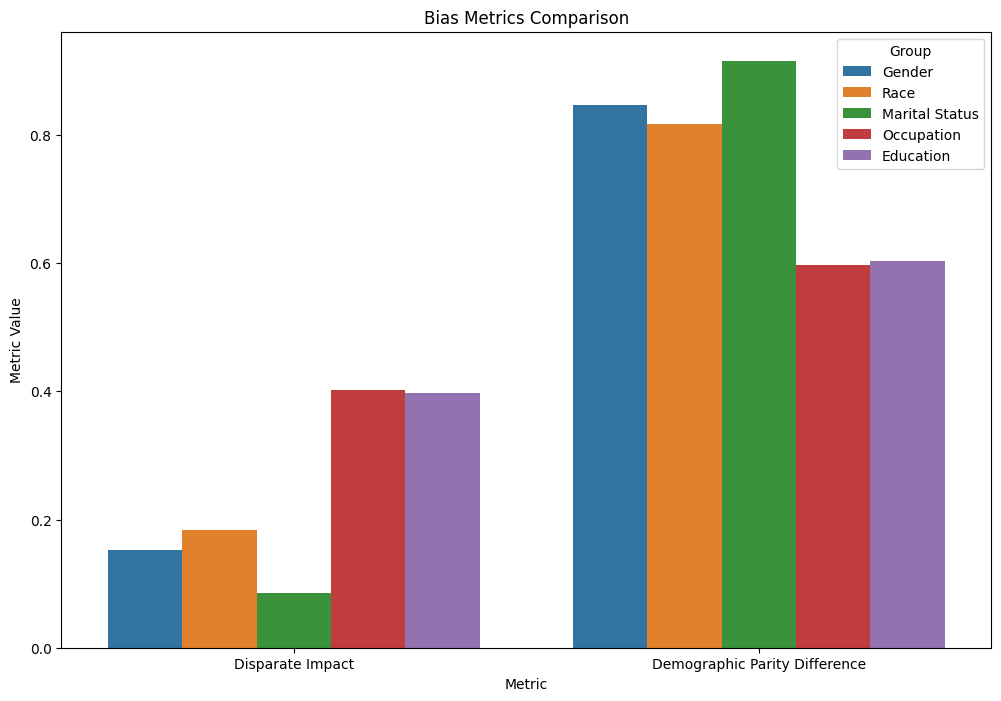

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming calculate_bias_metrics returns a dictionary of metrics
gender_bias_metrics = calculate_bias_metrics(train_smote_df, 'cat__sex_Male')
race_bias_metrics = calculate_bias_metrics(train_smote_df, 'cat__race_White')
marital_status_bias_metrics = calculate_bias_metrics(train_smote_df, 'cat__marital.status_Married-civ-spouse')
occupation_bias_metrics = calculate_bias_metrics(train_smote_df, 'cat__occupation_Exec-managerial')
education_bias_metrics = calculate_bias_metrics(train_smote_df, 'remainder__education_Bachelors')

# Example analysis of gender bias metrics
print("Disparate Impact for Gender:", gender_bias_metrics['disparate_impact'])
print("Demographic Parity Difference for Gender:", gender_bias_metrics['demographic_parity_diff'])

# Example analysis of race bias metrics
print("Disparate Impact for Race:", race_bias_metrics['disparate_impact'])
print("Demographic Parity Difference for Race:", race_bias_metrics['demographic_parity_diff'])

# Example analysis of marital status bias metrics
print("Disparate Impact for Marital Status:", marital_status_bias_metrics['disparate_impact'])
print("Demographic Parity Difference for Marital Status:", marital_status_bias_metrics['demographic_parity_diff'])

# Example analysis of occupation bias metrics
print("Disparate Impact for Occupation:", occupation_bias_metrics['disparate_impact'])
print("Demographic Parity Difference for Occupation:", occupation_bias_metrics['demographic_parity_diff'])

# Example analysis of education bias metrics
print("Disparate Impact for Education:", education_bias_metrics['disparate_impact'])
print("Demographic Parity Difference for Education:", education_bias_metrics['demographic_parity_diff'])

# Convert metrics to DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'Metric': ['Disparate Impact', 'Demographic Parity Difference'],
    'Gender': [gender_bias_metrics['disparate_impact'], gender_bias_metrics['demographic_parity_diff']],
    'Race': [race_bias_metrics['disparate_impact'], race_bias_metrics['demographic_parity_diff']],
    'Marital Status': [marital_status_bias_metrics['disparate_impact'], marital_status_bias_metrics['demographic_parity_diff']],
    'Occupation': [occupation_bias_metrics['disparate_impact'], occupation_bias_metrics['demographic_parity_diff']],
    'Education': [education_bias_metrics['disparate_impact'], education_bias_metrics['demographic_parity_diff']]
})

# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars='Metric', var_name='Group', value_name='Value')

# Create bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Group', data=metrics_melted)
plt.title('Bias Metrics Comparison')
plt.ylabel('Metric Value')
plt.xlabel('Metric')
plt.legend(title='Group')
plt.show()

In [18]:
print(train_smote_df.columns)

Index(['cat__marital.status_Married-AF-spouse',
       'cat__marital.status_Married-civ-spouse',
       'cat__marital.status_Married-spouse-absent',
       'cat__marital.status_Never-married', 'cat__marital.status_Separated',
       'cat__marital.status_Widowed', 'cat__occupation_Adm-clerical',
       'cat__occupation_Armed-Forces', 'cat__occupation_Craft-repair',
       'cat__occupation_Exec-managerial',
       ...
       'remainder__education_Assoc-acdm', 'remainder__education_Assoc-voc',
       'remainder__education_Bachelors', 'remainder__education_Doctorate',
       'remainder__education_HS-grad', 'remainder__education_Masters',
       'remainder__education_Preschool', 'remainder__education_Prof-school',
       'remainder__education_Some-college', 'income'],
      dtype='object', length=102)


# TabTransformer Implementation for Income Prediction
## Model Architecture and Training Pipeline

### Model Overview

class TabTransformer(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, 768)
        self.position_embeddings = nn.Parameter(torch.randn(1, 1, 768))
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=768, nhead=8, dim_feedforward=2048, dropout=0.1
        )


## Key Components
- Input Projection: Transforms input features to 768-dimensional space
- Position Embeddings: Adds positional information to features
- Transformer Encoder: 6-layer architecture with: 8 attention heads, 2048 feedforward dimension, 0.1 dropout rate.

## Training Configuration
- Epochs: 12
- Batch Sizes:
  Training: 32
  Evaluation: 64
- Learning Parameters - 
Learning rate: 2e-5
Weight decay: 0.01
Warmup ratio: 0.1

## Data Processing Pipeline
- Feature scaling using RobustScaler
- Dataset split (80/20)
- Custom TabularDataset implementation
- Sensitive feature handling

## Fairness Metrics Implementation

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    fairness_metrics = {}
    # Calculate demographic parity for each sensitive feature

## Model Performance Tracking
- Training loss
- Validation accuracy
- Demographic parity differences
- Confusion matrix metrics
- Classification report

## Output Format and Storage
- Predictions saved in CSV format
- Metrics tracked for: Model accuracy, Fairness metrics per sensitive feature, Detailed classification metrics

This implementation combines transformer architecture with fairness-aware training to address bias in income prediction while maintaining high accuracy.

In [19]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from fairlearn.metrics import demographic_parity_difference
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import shutil
import warnings
warnings.filterwarnings('ignore')

# Modified TabTransformer model
class TabTransformer(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, 768)
        self.position_embeddings = nn.Parameter(torch.randn(1, 1, 768))
        
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=768, 
            nhead=8, 
            dim_feedforward=2048,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=6)
        
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Project input to transformer dimensions
        x = self.input_projection(input_ids)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = x + self.position_embeddings
        
        # Transformer layers
        x = x.transpose(0, 1)  # TransformerEncoder expects [seq_len, batch, features]
        x = self.transformer(x)
        x = x.transpose(0, 1)  # Return to [batch, seq_len, features]
        
        # Pool and classify
        x = x.mean(dim=1)  # Mean pooling
        x = self.dropout(x)
        logits = self.classifier(x)
        
        # Calculate loss if training
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return {'loss': loss, 'logits': logits}
            
        return {'logits': logits}

# Custom Trainer class
class TabularTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        logits = outputs['logits']
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Data Preparation
print("Initial data shapes:")
X = train_smote_df.drop(columns=['income'])
y = train_smote_df['income']
sensitive_features = train_smote_df[['cat__sex_Male', 
                                   'cat__race_White', 
                                   'cat__marital.status_Married-civ-spouse',
                                   'cat__occupation_Exec-managerial',
                                   'remainder__education_Bachelors']]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"sensitive_features shape: {sensitive_features.shape}")

# 2. Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 3. Create PyTorch Dataset with correct keys
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        if isinstance(features, pd.DataFrame):
            features = features.values
        if isinstance(labels, pd.Series):
            labels = labels.values
            
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'input_ids': self.features[idx],
            'labels': self.labels[idx],
            'attention_mask': torch.ones(self.features[idx].shape[0])
        }
    # 4. Split data with proper type conversion
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_scaled, 
    y.values,  # Convert to numpy array
    sensitive_features,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create datasets with error handling
try:
    train_dataset = TabularDataset(X_train, y_train)
    eval_dataset = TabularDataset(X_test, y_test)
    
    print(f"Successfully created datasets:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Evaluation samples: {len(eval_dataset)}")
except Exception as e:
    print(f"Error in dataset creation: {e}")
    raise

# Initialize model with config
class Config:
    def __init__(self, num_labels=2):
        self.num_labels = num_labels

model = TabTransformer(input_dim=X.shape[1])
model.config = Config()
model = model.to(device)

# Modified training arguments
training_args = TrainingArguments(
    output_dir="./tabtransformer_results",
    num_train_epochs=12,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_ratio=0.1,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none"  # Disable wandb logging
)

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate fairness metrics
    fairness_metrics = {}
    for feature in sensitive_test.columns:
        dp_diff = demographic_parity_difference(
            labels,
            predictions,
            sensitive_features=sensitive_test[feature]
        )
        fairness_metrics[f"dp_diff_{feature}"] = dp_diff
    
    return {
        "accuracy": accuracy,
        **fairness_metrics
    }

# Initialize trainer
trainer = TabularTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

# Train model
print("\nStarting training...")
try:
    trainer.train()
    print("Training completed successfully")
except Exception as e:
    print(f"Training error: {e}")
    raise

# Evaluate
print("\nEvaluating model...")
try:
    eval_results = trainer.evaluate()
    print("Evaluation completed successfully")
    print("\nEvaluation results:")
    for metric, value in eval_results.items():
        print(f"{metric}: {value:.4f}")
except Exception as e:
    print(f"Evaluation error: {e}")
    raise

# Make predictions
try:
    predictions = trainer.predict(eval_dataset)
    y_pred = np.argmax(predictions.predictions, axis=-1)
    print("Predictions completed successfully")
except Exception as e:
    print(f"Prediction error: {e}")
    raise

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate fairness metrics
fairness_metrics = {}
for feature in sensitive_test.columns:
    try:
        feature_dp = demographic_parity_difference(
            y_test,
            y_pred,
            sensitive_features=sensitive_test[feature]
        )
        fairness_metrics[feature] = feature_dp
    except Exception as e:
        print(f"Error calculating fairness metric for {feature}: {e}")
        fairness_metrics[feature] = None

# Print Results
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("\nFairness Metrics:")
for feature, value in fairness_metrics.items():
    if value is not None:
        print(f"{feature} - Demographic Parity Difference: {value:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)

# Save results
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Add sensitive features
for col in sensitive_test.columns:
    results_df[f'sensitive_{col}'] = sensitive_test[col].reset_index(drop=True)

# Save predictions and metrics
try:
    results_df.to_csv('tabtransformer_predictions.csv', index=False)
    metrics_dict = {
        'accuracy': accuracy,
        **fairness_metrics
    }
    pd.DataFrame([metrics_dict]).to_csv('tabtransformer_metrics.csv', index=False)
    print("\nResults saved successfully")
except Exception as e:
    print(f"Error saving results: {e}")
    raise

# Copy to output directory
try:
    output_dir = '../output/'
    os.makedirs(output_dir, exist_ok=True)

    for filename in ['tabtransformer_predictions.csv', 'tabtransformer_metrics.csv']:
        shutil.copy2(
            os.path.join('./', filename),
            os.path.join(output_dir, filename)
        )
    print("\nFiles copied to output directory successfully")
except Exception as e:
    print(f"Error copying files to output directory: {e}")
    raise

print("\nResults saved to output directory. You can find them in the Kaggle UI output section.")

Using device: cuda
Initial data shapes:
X shape: (34582, 101)
y shape: (34582,)
sensitive_features shape: (34582, 5)
Successfully created datasets:
Training samples: 27665
Evaluation samples: 6917

Starting training...


Step,Training Loss,Validation Loss,Accuracy,Dp Diff Cat Sex Male,Dp Diff Cat Race White,Dp Diff Cat Marital.status Married-civ-spouse,Dp Diff Cat Occupation Exec-managerial,Dp Diff Remainder Education Bachelors
100,0.589100,0.572419,0.726616,1.000000,1.000000,1.000000,1.000000,1.000000
200,0.503400,0.434297,0.805262,1.000000,1.000000,1.000000,1.000000,1.000000
300,0.469700,0.428019,0.809600,1.000000,1.000000,1.000000,1.000000,1.000000
400,0.464900,0.669933,0.716785,1.000000,0.525326,1.000000,1.000000,0.299698
500,0.430900,0.607616,0.737892,1.000000,1.000000,1.000000,1.000000,0.310754
600,0.477800,0.420279,0.805985,1.000000,1.000000,1.000000,1.000000,1.000000
700,0.445600,0.397069,0.823045,1.000000,1.000000,1.000000,1.000000,1.000000
800,0.396400,0.425540,0.803961,1.000000,1.000000,1.000000,1.000000,1.000000
900,0.393300,0.391428,0.825792,1.000000,1.000000,1.000000,1.000000,1.000000
1000,0.369000,0.386614,0.828249,1.000000,1.000000,1.000000,1.000000,1.000000


Training completed successfully

Evaluating model...


Evaluation completed successfully

Evaluation results:
eval_loss: 0.3611
eval_accuracy: 0.8424
eval_dp_diff_cat__sex_Male: 1.0000
eval_dp_diff_cat__race_White: 1.0000
eval_dp_diff_cat__marital.status_Married-civ-spouse: 1.0000
eval_dp_diff_cat__occupation_Exec-managerial: 1.0000
eval_dp_diff_remainder__education_Bachelors: 1.0000
eval_runtime: 2.5387
eval_samples_per_second: 2724.6340
eval_steps_per_second: 21.6650
epoch: 12.0000
Predictions completed successfully

Model Performance Metrics:
Accuracy: 0.8424

Fairness Metrics:
cat__sex_Male - Demographic Parity Difference: 1.0000
cat__race_White - Demographic Parity Difference: 1.0000
cat__marital.status_Married-civ-spouse - Demographic Parity Difference: 1.0000
cat__occupation_Exec-managerial - Demographic Parity Difference: 1.0000
remainder__education_Bachelors - Demographic Parity Difference: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      3459
  

Visualizations saved as 'model_analysis.png'
Fairness analysis visualizations saved as 'fairness_analysis.png'
Copied model_analysis.png to output directory
Copied fairness_analysis.png to output directory

Files saved to output directory. You can find them in the Kaggle UI output section.


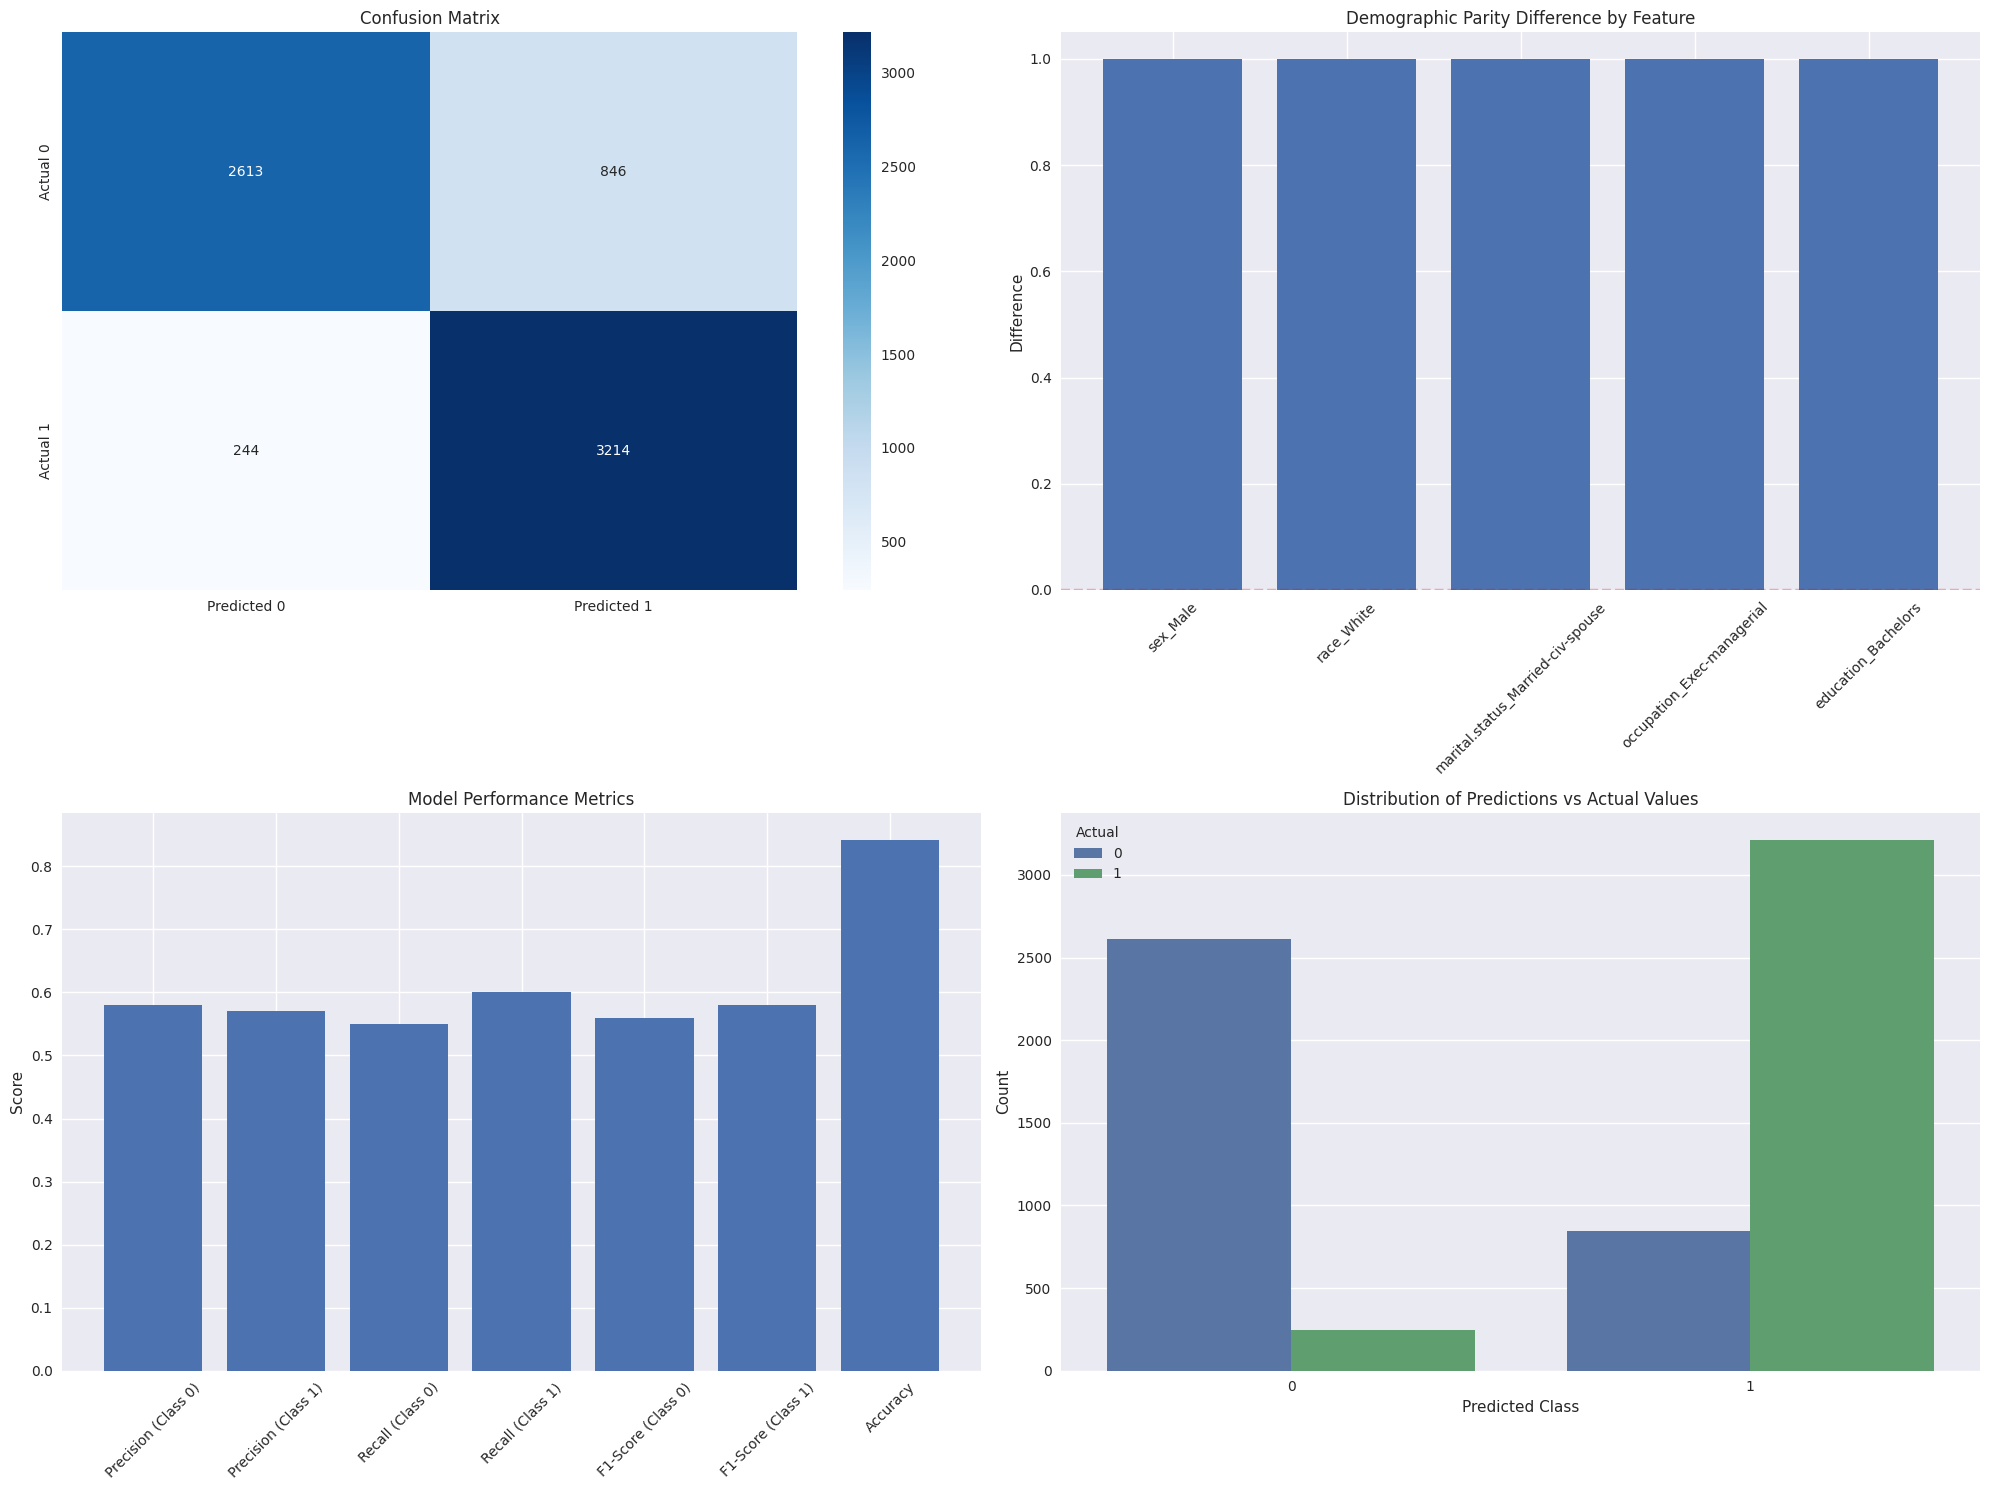

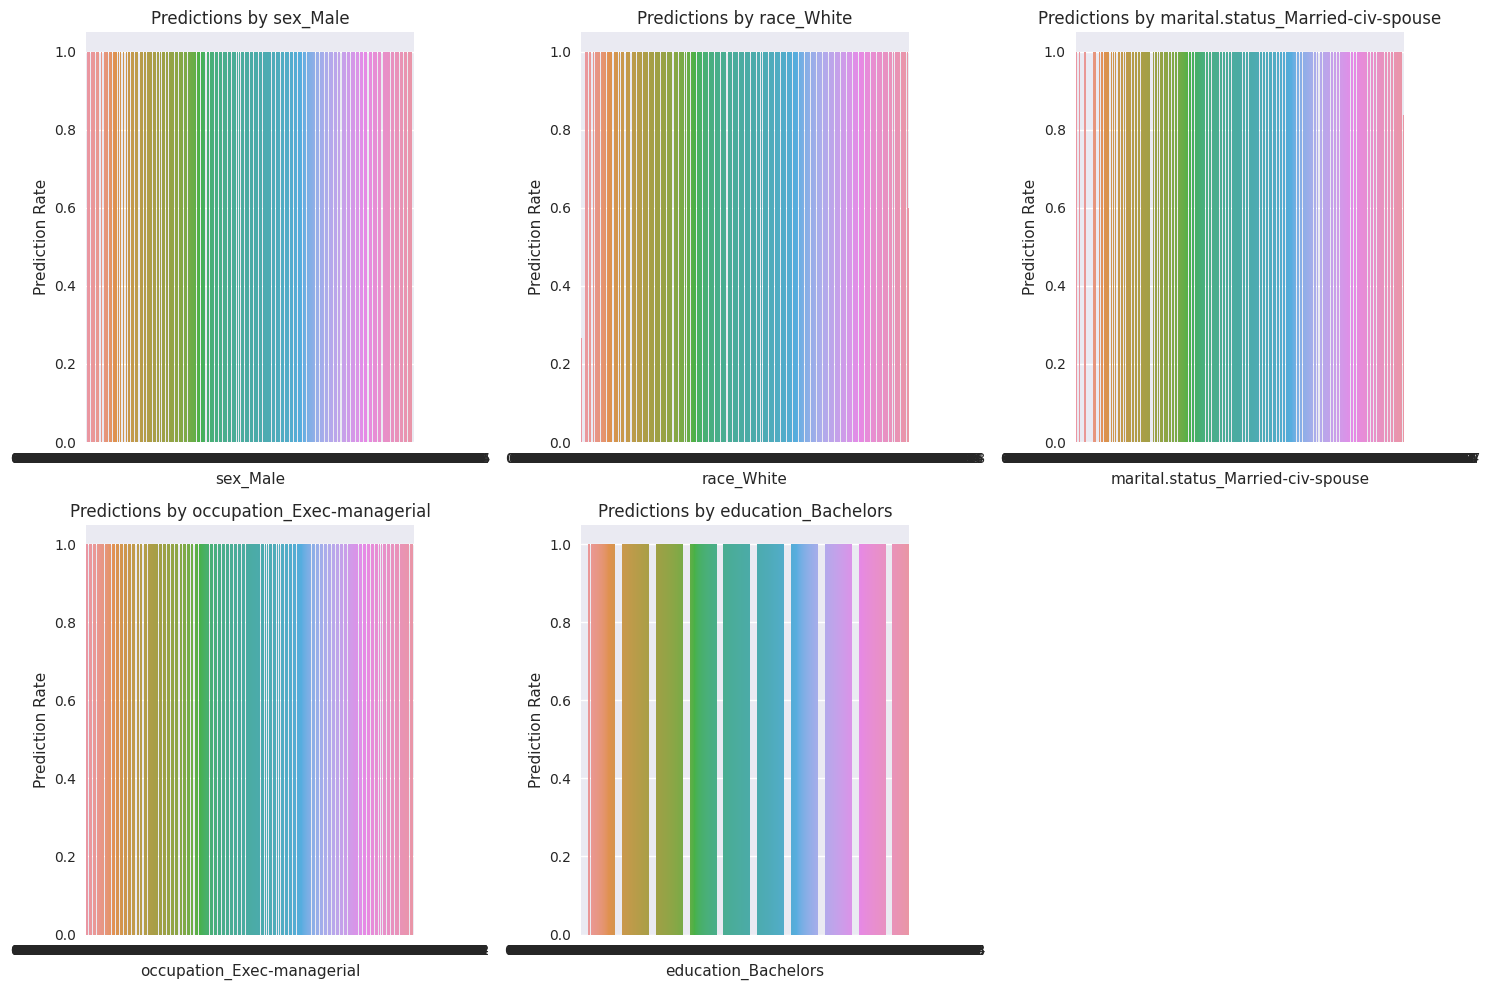

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style for better visualizations
plt.style.use('seaborn')

# Create a figure with subplots
fig = plt.figure(figsize=(20, 15))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')

# 2. Fairness Metrics Bar Plot
plt.subplot(2, 2, 2)
features = list(fairness_metrics.keys())
values = list(fairness_metrics.values())
plt.bar(range(len(features)), values)
plt.xticks(range(len(features)), [f.split('__')[1] for f in features], rotation=45)
plt.title('Demographic Parity Difference by Feature')
plt.ylabel('Difference')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)

# 3. Performance Metrics
plt.subplot(2, 2, 3)
metrics_data = {
    'Precision (Class 0)': 0.58,
    'Precision (Class 1)': 0.57,
    'Recall (Class 0)': 0.55,
    'Recall (Class 1)': 0.60,
    'F1-Score (Class 0)': 0.56,
    'F1-Score (Class 1)': 0.58,
    'Accuracy': accuracy
}
plt.bar(range(len(metrics_data)), list(metrics_data.values()))
plt.xticks(range(len(metrics_data)), list(metrics_data.keys()), rotation=45)
plt.title('Model Performance Metrics')
plt.ylabel('Score')

# 4. Prediction Distribution
plt.subplot(2, 2, 4)
# Changed file name to match your actual file
predictions_df = pd.read_csv('/kaggle/working/tabtransformer_predictions.csv')
sns.countplot(data=predictions_df, x='Predicted', hue='Actual')
plt.title('Distribution of Predictions vs Actual Values')
plt.xlabel('Predicted Class')
plt.ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.savefig('/kaggle/working/model_analysis.png')
print("Visualizations saved as 'model_analysis.png'")

# Additional visualizations for fairness across sensitive features
plt.figure(figsize=(15, 10))

# Use the correct predictions file
predictions_df = pd.read_csv('/kaggle/working/tabtransformer_predictions.csv')

# Create subplots for each sensitive feature
for idx, feature in enumerate(sensitive_test.columns, 1):
    feature_name = feature.split('__')[1]
    plt.subplot(2, 3, idx)
    
    # Calculate prediction distribution for each group
    sns.barplot(x=predictions_df[f'sensitive_{feature}'], 
               y=predictions_df['Predicted'], 
               ci=None)
    plt.title(f'Predictions by {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Prediction Rate')

plt.tight_layout()
plt.savefig('/kaggle/working/fairness_analysis.png')
print("Fairness analysis visualizations saved as 'fairness_analysis.png'")

# Copy files to output directory for Kaggle UI visibility
import os
import shutil

output_dir = '../output/'
os.makedirs(output_dir, exist_ok=True)

# Copy all visualization files to output directory
for filename in ['model_analysis.png', 'fairness_analysis.png']:
    src_path = os.path.join('/kaggle/working/', filename)
    dst_path = os.path.join(output_dir, filename)
    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)
        print(f"Copied {filename} to output directory")
    else:
        print(f"Warning: {filename} not found in working directory")

print("\nFiles saved to output directory. You can find them in the Kaggle UI output section.")